# Notebook for property analysis in Helsinki

In [1]:
import requests
import json
import pandas as pd
import re
import numpy as np
from datetime import datetime
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import bs4 as bs
from matplotlib import ticker
import watermark

In [2]:
%load_ext watermark

In [3]:
%watermark -iv

bs4       4.6.0
pandas    0.20.1
watermark 1.8.0
seaborn   0.9.0
json      2.0.9
numpy     1.15.2
requests  2.18.4
re        2.2.1
matplotlib2.0.2



## Series from Tilastokeskus

In [4]:
# http://pxnet2.stat.fi/PXWeb/pxweb/fi/StatFin/
# https://www.stat.fi/static/media/uploads/org/avoindata/px-web_api-ohje.pdf

In [5]:
def try_parsing_date(text):
    for fmt in ('%Y-%m-%d','%m/%d/%y','%m/%d/%Y','%m-%d-%y','%m-%d-%Y',
                '%d %b %Y','%d %B %Y','%B %d, %Y','%b %d, %Y',
                '%B. %d, %Y','%b %d %Y','%b. %d, %Y','%B %d %Y',
                '%B %Y','%B, %Y','%b, %Y','%b %Y','%m/%Y','%Y','%Y%m'
                ,'%Y-%Q'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    print(text)
    raise ValueError('no valid date format found')

In [6]:
def monthly_series(URL,dict_query):
    json_query = json.dumps(dict_query)
    resp = requests.post(URL,data=json_query)

    print(resp)
    if resp.status_code == 404:
        raise ValueError('Reposen 404, abort!')

    for x in resp.text.split(';'):
        if 'TIMEVAL("Kuukausi")' in x:
            #print(x)
            pattern = re.compile('[0-9]{6}')
            dates = pattern.findall(x)
        if 'DATA' in x:
            #print(x)
            pattern = re.compile('[0-9]+\.[0-9]+')
            values = pattern.findall(x)
    df = pd.DataFrame(data = {'dates': pd.Series(dates,dtype=str), 'values':pd.Series(values,dtype=np.float64)})
    df['dates'] = [try_parsing_date(x) for x in df['dates']]
    return df
    

### Monthly series

In [7]:
URL = "https://pxnet2.stat.fi:443/PXWeb/api/v1/fi/StatFin/asu/ashi/kk/statfin_ashi_pxt_112n.px"
dict_query = {
 "query": [
 {
 "code": "Alue",
 "selection": {
 "filter": "item",
 "values": [
 "091",
 ]
 }
 },
 {
 "code": "Talotyyppi",
 "selection": {
 "filter": "item",
 "values": [
 "3",
 ]
 }
 },
 {
 "code": "Tiedot",
 "selection": {
 "filter": "item",
 "values": [
 "CHANGE",
 ]
 }
 },      
],
 "response": {
 "format": "px"
 }
}

#### Helsinki, vanhojen kerrotaloosakkeiden neliöhinta, kk sarja

<Response [200]>


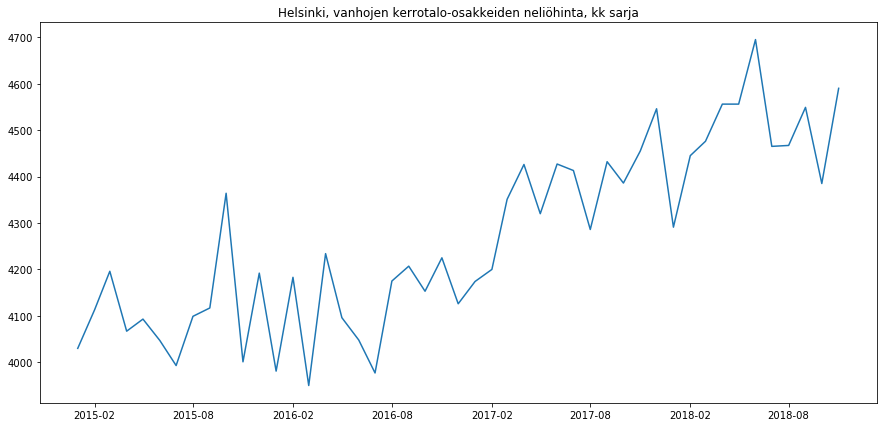

In [8]:
# Data
dict_query['query'][2]['selection']['values'][0] = 'keskihinta'
df = monthly_series(URL,dict_query)
df.tail()

# Figure
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
lns1 = ax.plot(df['dates'],df['values'])
ax.set_title('Helsinki, vanhojen kerrotalo-osakkeiden neliöhinta, kk sarja')

#### Helsinki, vanhojen kerrotaloosakkeiden hintaindeksi, kk sarja

<Response [200]>


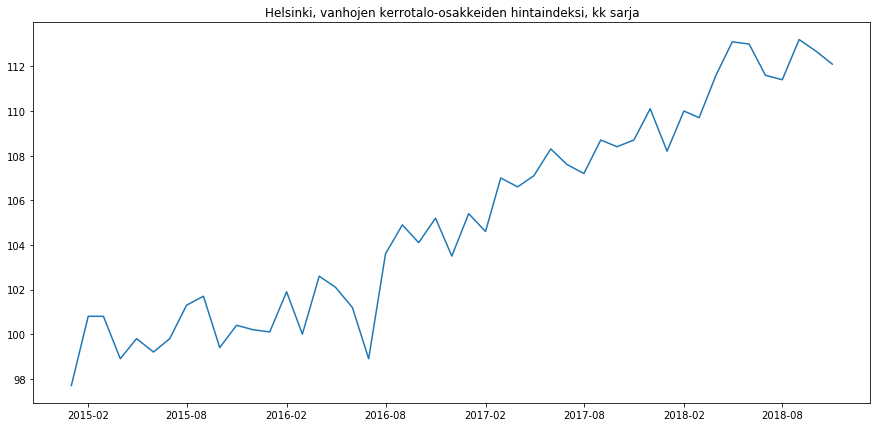

In [9]:
# Data
dict_query['query'][2]['selection']['values'][0] = 'ketjutettu_lv'
df = monthly_series(URL,dict_query)
df.tail()

# Figure
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
lns1 = ax.plot(df['dates'],df['values'])
ax.set_title('Helsinki, vanhojen kerrotalo-osakkeiden hintaindeksi, kk sarja')

#### Helsinki, vanhojen kerrotaloosakkeiden kauppojen lkm, kk sarja

<Response [200]>


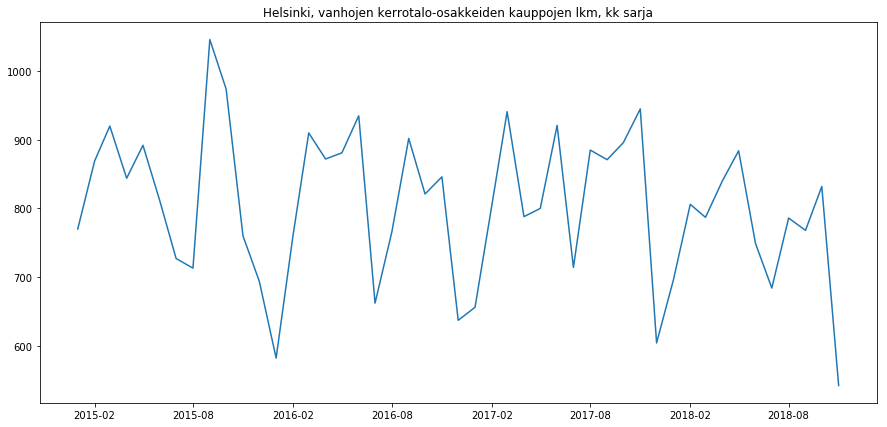

In [10]:
# Data
dict_query['query'][2]['selection']['values'][0] = 'lkm_julk'
df = monthly_series(URL,dict_query)
df.tail()

# Figure
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
lns1 = ax.plot(df['dates'],df['values'])
ax.set_title('Helsinki, vanhojen kerrotalo-osakkeiden kauppojen lkm, kk sarja')

### Quarterly series

#### Whole country property price index

In [11]:
import rpy2 # for using R inside Python kernel
%load_ext rpy2.ipython

In [12]:
%%R -o data
require(BIS)
datasets = get_datasets()
data = get_bis(datasets$url[datasets$name == "Property prices: long series"], quiet = FALSE)
data = data[data$reference_area %in% c('Finland'),]


In [13]:
data = pd.DataFrame(rpy2.robjects.pandas2ri.ri2py(data))
data = data[['date','obs_value']]
data['date'] = pd.to_datetime(data['date'])

,date,obs_value
189,2017-04-01,270.3963
190,2017-07-01,268.8165
191,2017-10-01,267.5001
192,2018-01-01,267.7634
193,2018-04-01,272.2392


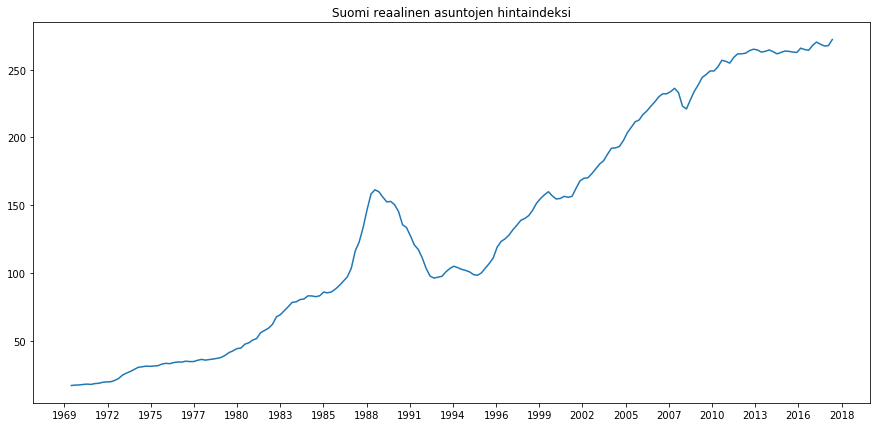

In [14]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
lns1 = ax.plot(data['date'],data['obs_value'])
ax.set_title('Suomi reaalinen asuntojen hintaindeksi')
ax.xaxis.set_major_locator(ticker.MaxNLocator(20)),
data.tail()

## Avoin asuntojen hintatiedot

In [29]:
# URL where to get data from, increment search number for next page in table
# Settings: city:Helsinki, no zip core or area selction, kerrostalo, room count = {1,2}, no filter on size
#http://asuntojen.hintatiedot.fi/haku/?c=Helsinki&cr=1&h=1&r=1&r=2&t=3&l=0&z=1&search=1&sf=0&so=a&submit=seuraava+sivu+%C2%BB

#area_file_name = None
#area_file_name = 'pickles/area_data_fetched_2019-01-06-1729.pkl'
area_file_name = 'pickles/area_data_fetched_2019-01-08-1621.pkl'

In [30]:
def get_area_data():
    max_iters = 200
    for i in range(max_iters):
        url = "http://asuntojen.hintatiedot.fi/haku/?c=Helsinki&cr=1&h=1&r=1&r=2&t=3&l=0&z="+str(i+1)+"&search=1&sf=0&so=a&submit=seuraava+sivu+%C2%BB"
        resp = requests.get(url)

        # Get page
        soup = bs.BeautifulSoup(resp.content,'lxml')

        # Get table
        table = soup.find(lambda tag: tag.name=='table' and tag.has_attr('id') and tag['id']=="mainTable") 

        # Reduce to body tag with data
        tab_red = table.find_all("tbody")[2]

        # Get rows of table
        rows = tab_red.findAll(lambda tag: tag.name=='tr')

        # Extract data out of row texts
        row_data = []
        apt_type = None
        for row in rows:
            cols = row.find_all('td')
            if len(cols) == 1:
                apt_type = cols[0].text.strip()
                print("New apt_type {} table page found".format(apt_type))
                continue
            cols = [ele.text.strip() for ele in cols]

            # Force empty cells to missing np.nan
            cols = [x if x != '' else np.nan for x in cols]        
            row_data.append([ele for ele in cols if ele]) # Get rid of empty values

        # If return empty data, then abort
        lengths = [len(x) for x in row_data]
        if max(lengths) < 11: # we should have 11 features
            print("Aborting looping at page {}".format(i+1))
            break

        # Data as data frame
        headers = ['neighborhood','apt','talot','size','price','price_sqm','year_built','floor_str','elevator','condition','energy']
        df_temp = pd.DataFrame(row_data, columns = headers)
        df_temp['apt_type'] = apt_type
        df_temp['fetch_tab_no'] = i+1

        # Save data frame
        if i == 0:
            area_data = df_temp
        else:
            area_data = area_data.append(df_temp,ignore_index = True)

    area_data.loc[area_data['apt_type'] == 'Yksiö','apt_type'] = 'single'
    area_data.loc[area_data['apt_type'] == 'Kaksi huonetta','apt_type'] = 'double'
    
    return area_data, datetime.now()

In [31]:
def clean_area_data(area_data):
    area_data['floor'] = np.nan
    area_data['max_floor'] = np.nan
    for index, row in area_data.iterrows():
        if pd.isnull(row['floor_str']) == False:
            area_data.set_value(index, 'floor', row['floor_str'].split('/')[0])
            area_data.set_value(index, 'max_floor', row['floor_str'].split('/')[1])
    del area_data['floor_str']
    
    # Force types
    area_data['size'] = area_data['size'].str.replace(',','.') # not sure if needed
    area_data['size'] = area_data['size'].astype(np.float64)
    area_data['price'] = area_data['price'].astype(np.float64)
    area_data['price_sqm'] = area_data['price_sqm'].astype(np.float64)
    area_data['year_built'] = area_data['year_built'].astype(np.int64)
    
    # Correct possibly corrupted names
    area_data.loc[area_data['neighborhood'] == 'Etel�-haaga','neighborhood'] = 'Etelä-haaga'
    area_data.loc[area_data['neighborhood'] == 'Taka-t��l�','neighborhood'] = 'Taka-töölö'
    area_data.loc[area_data['neighborhood'] == 'Pukinm�ki','neighborhood'] = 'Pukinmäki'
    area_data.loc[area_data['neighborhood'] == 'Brunak�rr','neighborhood'] = 'Brunakärr'
    area_data.loc[area_data['neighborhood'] == 'Kannelm�ki','neighborhood'] = 'Kannelmäki'
    
    # Force to lower case just in case
    area_data['neighborhood'] = area_data['neighborhood'].str.lower()    
    
    return area_data

### Get data anew or load previously fetched

In [35]:
if area_file_name == None:
    # Import data anew and write to csv
    area_data, timestamp = get_area_data()
    area_data = clean_area_data(area_data)
    area_data.to_pickle('pickles/area_data_' + timestamp.strftime('fetched_%Y-%m-%d-%H%M') + ".pkl")
    print("Fetched area_data anew and saved it to pickle")
else:
    # Previously fetched
    area_data = pd.read_pickle(area_file_name)
    print("Imported previously fetched area_data file: {}".format(area_file_name))

Imported previously fetched area_data file: pickles/area_data_fetched_2019-01-08-1621.pkl


In [36]:
# Lump some pre-defined areas together
area_data.loc[area_data['neighborhood'] == 'hietalahti, kamppi','neighborhood'] = 'kamppi'
area_data.loc[area_data['neighborhood'] == 'hernesaari, eira','neighborhood'] = 'eira'
area_data.loc[area_data['neighborhood'] == 'kallio, harju','neighborhood'] = 'harju'
area_data.loc[area_data['neighborhood'] == 'kallio, torkkelinmäki','neighborhood'] = 'torkkelinmäki'
area_data.loc[area_data['neighborhood'] == 'vallila, hermanni','neighborhood'] = 'hermanni'    
area_data.loc[area_data['neighborhood'] == 'kamppi, bulevardi','neighborhood'] = 'kamppi' 

In [37]:
area_data.tail()

,neighborhood,apt,talot,size,price,price_sqm,year_built,elevator,condition,energy,apt_type,fetch_tab_no,floor,max_floor
1888,vuosaari,"2h, k, s",kt,58.5,179000.0,3060.0,1993,on,hyvä,NaN,double,37,5.0,6.0
1889,kamppi,"2h, alkovi, kk,...",kt,42.0,335100.0,7979.0,1929,on,hyvä,G,double,37,3.0,4.0
1890,konala,"2h,k,kph,vh, la...",kt,50.0,137000.0,2740.0,1964,ei,tyyd.,D2007,double,37,3.0,3.0
1891,tapaninvainio,"2h, k, kph/s, wc",kt,50.0,164000.0,3280.0,1982,ei,hyvä,NaN,double,37,1.0,4.0
1892,viikki,"2h, avok, kph, ...",kt,50.5,238000.0,4713.0,2004,on,hyvä,NaN,double,37,2.0,6.0


In [38]:
area_data['neighborhood'].unique()

array(['pohjois-haaga', 'taka-töölö', 'punavuori', 'sörnäinen', 'kallio',
       'harju', 'etelä-haaga', 'kluuvi', 'meilahti', 'torkkelinmäki',
       'herttoniemi', 'kuninkaantammi', 'malminkartano', 'käpylä',
       'lassila', 'vallila', 'etu-töölö', 'kruununhaka', 'alppila',
       'toukola', 'kontula', 'lauttasaari', 'töölö', 'kamppi',
       'kamppi hietalahti', 'katajanokka', 'alppiharju', 'siltasaari',
       'pasila', 'roihuvuori', 'pihlajisto', 'puotila', 'jätkäsaari',
       'puotinharju', 'ullanlinna', 'munkkiniemi', 'tapulikaupunki',
       'aurinkolahti', 'kallahti', 'munkkivuori', 'hermanni', 'oulunkylä',
       'viikki', 'mellunkylä', 'malmi', 'vuosaari', 'eira', 'hakaniemi',
       'myllypuro', 'kumpula', 'merihaka', 'pihlajamäki',
       'kaartinkaupunki', 'vartiokylä', 'siltamäki', 'heikinlaakso',
       'laajasalo', 'pitäjänmäki', 'mellunmäki', 'lehtisaari',
       'ruskeasuo', 'konala', 'kaisaniemi', 'kannelmäki', 'kulosaari',
       'munkkisaari', 'kalasatama', 'ja

In [39]:
int_locs = sorted([
        'töölö'
       ,'alppiharju'
       ,'kamppi'
       ,'pasila'
       ,'sörnäinen'
       ,'punavuori'
       ,'vallila'
       ,'jätkäsaari'
       ,'kallio'
       ,'ullanlinna'
       ,'meilahti'
       ,'kruununhaka'
       ,'etu-töölö'
       ,'alppila'
       ,'hermanni'
       ,'lauttasaari'
       ,'eira'
       ,'taka-töölö'
       ,'hakaniemi'
       ,'kumpula'
       ,'merihaka'
       ,'kaartinkaupunki'
       ,'torkkelinmäki'
       ,'kluuvi'
       ,'katajanokka'
       ,'kaisaniemi'
       ,'kalasatama'
       ,'länsi-pasila'
       ,'harju'
       ,'itä-pasila'
       ,'pikku-huopalahti'
       ,'keski-töölö'
       ,'arabianranta'
       ,'hietalahti'
       ,'keskusta'
       ,'eiranranta'
])

east = sorted([
        'alppiharju'
       ,'sörnäinen'
       ,'vallila'
       ,'kallio'
       ,'alppila'
       ,'hermanni'
       ,'hakaniemi'
       ,'torkkelinmäki'
       ,'kalasatama'
       ,'harju'
])

north = sorted([
        'pasila'
       ,'meilahti'
       ,'kumpula'
       ,'länsi-pasila'
       ,'itä-pasila'
       ,'pikku-huopalahti'
       ,'arabianranta'
])

south = sorted([
        'töölö'
       ,'kamppi'
       ,'punavuori'
       ,'jätkäsaari'
       ,'ullanlinna'
       ,'kruununhaka'
       ,'etu-töölö'
       ,'lauttasaari'
       ,'eira'
       ,'taka-töölö'
       ,'merihaka'
       ,'kaartinkaupunki'
       ,'kluuvi'
       ,'katajanokka'
       ,'kaisaniemi'
       ,'keski-töölö'
       ,'hietalahti'
       ,'keskusta'
       ,'eiranranta'
])

# Check
print(set(int_locs) == set(south + north + east))

import collections
print(collections.Counter(int_locs) == collections.Counter(south + north + east))

print(len(int_locs) == len(south + north + east))


True
True
True


In [40]:
area_data['int_locs'] = np.nan
area_data.loc[area_data['neighborhood'].isin(int_locs),'int_locs'] = True
area_data.loc[~area_data['neighborhood'].isin(int_locs),'int_locs'] = False

area_data['area'] = 'other'
area_data.loc[area_data['neighborhood'].isin(east),'area'] = 'east'
area_data.loc[area_data['neighborhood'].isin(north),'area'] = 'north'
area_data.loc[area_data['neighborhood'].isin(south),'area'] = 'south'


### Plots

C:\Users\ville_000\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


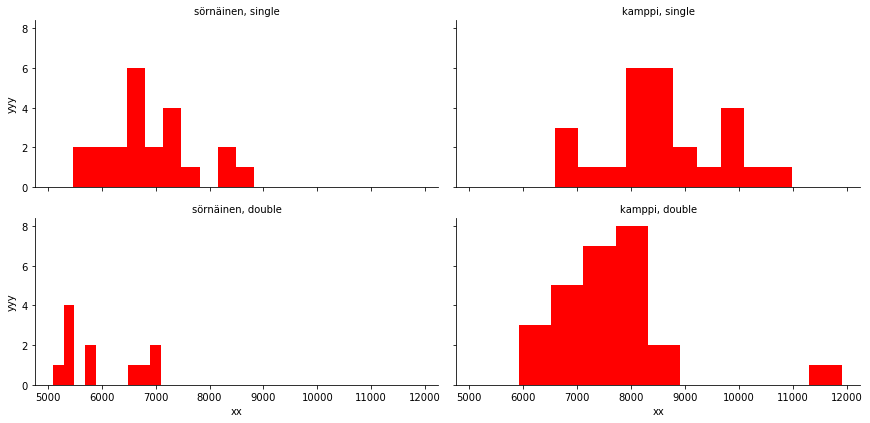

In [41]:
df_test = area_data[area_data['neighborhood'].isin(['kamppi','sörnäinen'])]
g = sns.FacetGrid(df_test, col = "neighborhood", row = "apt_type", size = 3, aspect = 2)
g = (g.map(plt.hist, "price_sqm", color = 'r')
        .set_titles("{col_name}, {row_name}")
        .set_axis_labels("xx", "yyy")
    )

C:\Users\ville_000\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


(100000, 400000)

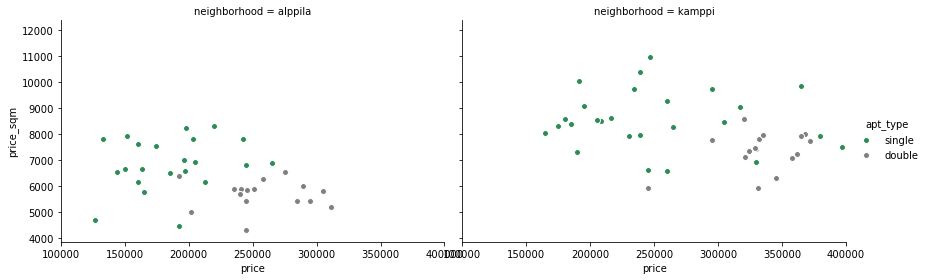

In [42]:
df_test = area_data[area_data['neighborhood'].isin(['alppila', 'kamppi'])]
pal = dict(single = "seagreen", double = "gray")
g2 = sns.FacetGrid(df_test, col = "neighborhood",  hue = "apt_type", palette = pal, size = 4, aspect = 1.5)
g2 = (g2.map(plt.scatter, "price", "price_sqm", edgecolor="w").add_legend())
axes = g2.axes
axes[0,0].set_xlim(100000,400000)
axes[0,1].set_xlim(100000,400000)

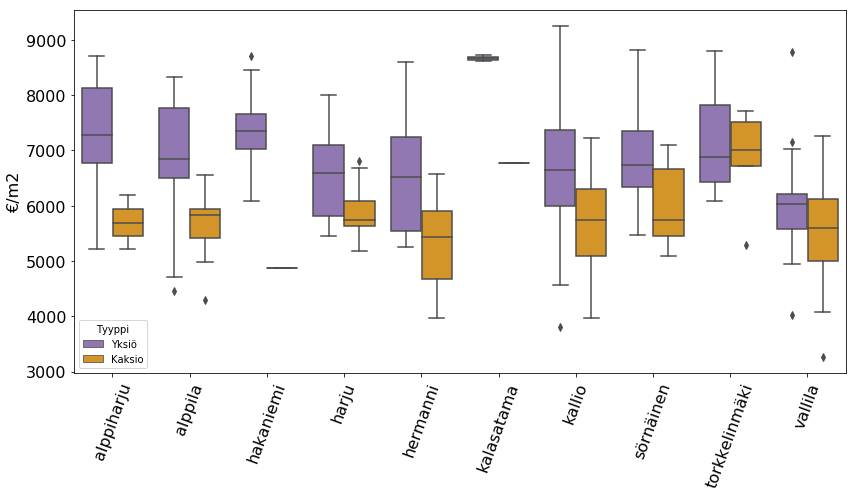

In [43]:
area = 'east'
variable = 'price_sqm'

df_test = area_data[area_data['area'] == area]
df_test = df_test.sort_values(['neighborhood'], ascending  = [True])
df_test.loc[df_test['apt_type'] == 'single','apt_type'] = 'Yksiö'
df_test.loc[df_test['apt_type'] == 'double','apt_type'] = 'Kaksio'
df_test.rename(columns = {"apt_type": "Tyyppi"}, inplace = True)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)


sns.boxplot(x = "neighborhood", y = variable, hue = "Tyyppi", data = df_test, palette = sns.color_palette(["#916FBB","#F09B0C"]),ax=ax)
#ax.set_ylabel(variable,fontsize = 16)
ax.set_ylabel('€/m2',fontsize = 16)
ax.set_xlabel('',fontsize = 1)
plt.xticks(rotation=70, size = 16)
plt.yticks(size = 16)
fig.tight_layout()
plt.savefig("pics/" + area + "_boxplot_" + variable + ".png", dpi=300)

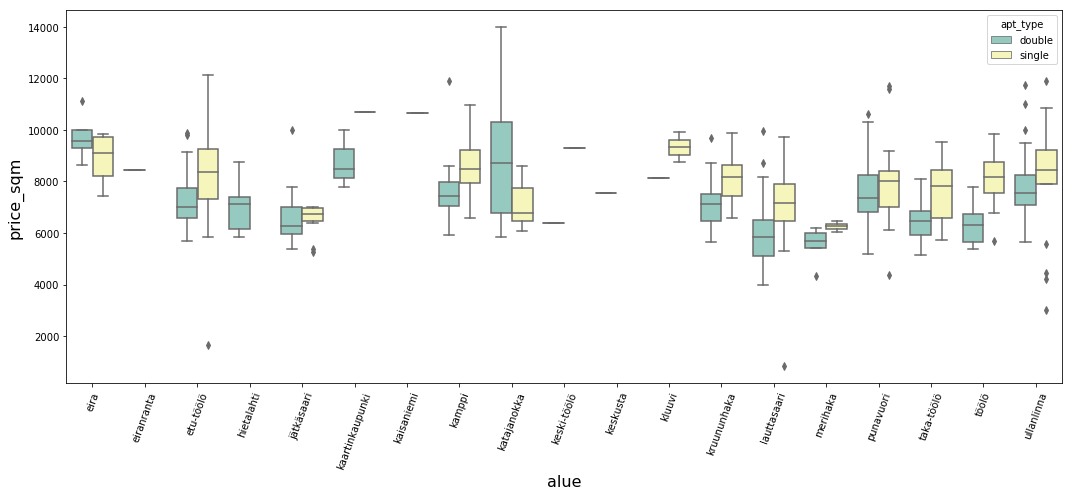

In [27]:
area = 'south'
variable = 'price_sqm'

df_test = area_data[area_data['area'] == area]
df_test = df_test.sort_values(['neighborhood'], ascending  = [True])

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)

sns.boxplot(x = "neighborhood", y = variable, hue = "apt_type", data = df_test, palette = 'Set3',ax=ax)
ax.set_ylabel(variable,fontsize = 16)
ax.set_xlabel('alue',fontsize = 16)
plt.xticks(rotation=70)
fig.tight_layout()
plt.savefig("pics/" + area + "_boxplot_" + variable + ".png", dpi=300)

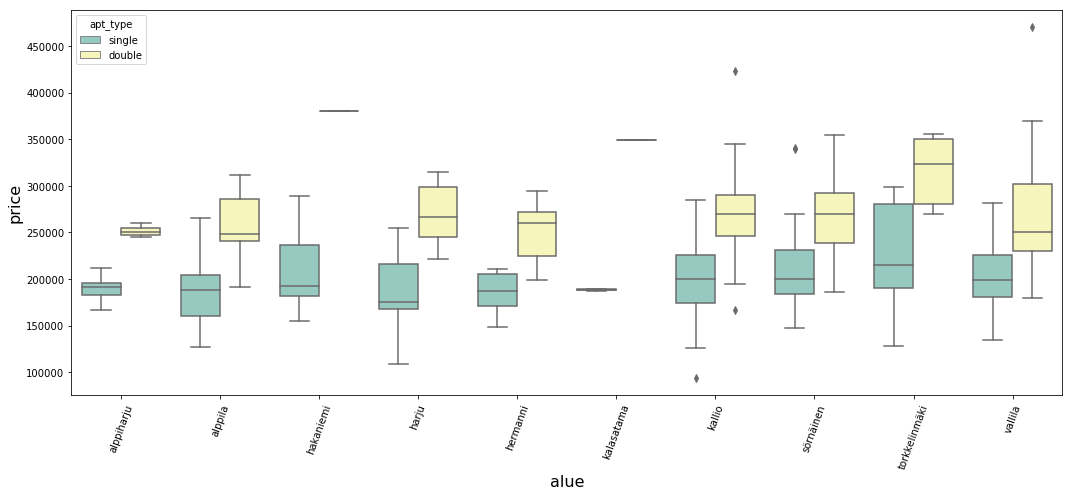

In [28]:
area = 'east'
variable = 'price'

df_test = area_data[area_data['area'] == area]
df_test = df_test.sort_values(['neighborhood'], ascending  = [True])

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)

sns.boxplot(x = "neighborhood", y = variable, hue = "apt_type", data = df_test, palette = 'Set3',ax=ax)
ax.set_ylabel(variable,fontsize = 16)
ax.set_xlabel('alue',fontsize = 16)
plt.xticks(rotation=70)
fig.tight_layout()
plt.savefig("pics/" + area + "_boxplot_" + variable + ".png", dpi=300)